In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import losses
import pickle
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
dataDir = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"

IMG_SHAPE = 256
batch_size = 16
dropout_rate = 0.2
num_epochs=50

In [3]:
pickle_in = open("/home/trojan/Desktop/dimentia/CNN_simple/kfold/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/home/trojan/Desktop/dimentia/CNN_simple/kfold/y.pickle","rb")
y = pickle.load(pickle_in)

In [4]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(19677, 256, 256, 3)
(19677,)


In [5]:
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  shuffle=True, stratify=y, 
                                                  test_size=0.2, random_state=42)

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print('y_train shape:', y_train.shape)

x_train shape: (15741, 256, 256, 3)
15741 train samples
3936 validation samples
y_train shape: (15741,)


In [7]:
#print(x_train[1].dtype)
print(np.min(x_train[1]), np.max(x_train[1]))

0 1


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [9]:
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((x_val,y_val_enc))

In [10]:
IMG_SHAPE = 256
BS = 16
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

In [11]:
# Model Bulding

# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])



In [12]:
initializer = 'he_normal'
# Encoder Network
def encoder_net():
    inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
    normalization_layer = UnitNormLayer()

    encoder = tf.keras.applications.Xception(weights=None, include_top=False)
    #encoder = tf.keras.applications.ResNet50V2(weights=None, include_top=False)
    #encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
    #encoder = Sequential()

    '''encoder.add(Conv2D(32, (5, 5), padding='same', input_shape = (256, 256, 3), kernel_initializer=initializer))
    #model.add(Dropout(0.2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(Conv2D(64, (5, 5), padding='same', kernel_initializer=initializer))
    #model.add(Dropout(0.2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    #model.add(Dropout(0.2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))

    encoder.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer))
    #model.add(Dropout(0.2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))

    encoder.add(Conv2D(512, (3, 3), padding='same', kernel_initializer=initializer))
    #model.add(Dropout(0.2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2)))'''

    encoder.trainable = True

    embeddings = encoder(inputs, training=True)
    embeddings = GlobalAveragePooling2D()(embeddings)
    norm_embeddings = normalization_layer(embeddings)

    encoder_network = Model(inputs, norm_embeddings)

    return encoder_network

# Projector Network
def projector_net():
    projector = tf.keras.models.Sequential([
        Dense(256, activation="relu"),
        UnitNormLayer()
])

    return projector

In [13]:
encoder_r = encoder_net()
projector_z = projector_net()

In [14]:
def lr_schedule(epoch):

    lr = 1e-3 
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [15]:
#Training encoder and the projector

optimizer = tf.keras.optimizers.Adam(lr=lr_schedule(0))

encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Learning rate:  0.001


Epoch: 0 Loss: 0.264
Epoch Time: 387.3918535709381
Total Time: 387.3918535709381
Epoch: 1 Loss: 0.249
Epoch Time: 272.3926193714142
Total Time: 659.7844729423523
Epoch: 2 Loss: 0.230
Epoch Time: 242.48972535133362
Total Time: 902.2741982936859
Epoch: 3 Loss: 0.212
Epoch Time: 246.77226376533508
Total Time: 1149.046462059021
Epoch: 4 Loss: 0.194
Epoch Time: 247.63143110275269
Total Time: 1396.6778931617737
Epoch: 5 Loss: 0.169
Epoch Time: 246.63129687309265
Total Time: 1643.3091900348663
Epoch: 6 Loss: 0.148
Epoch Time: 245.5429768562317
Total Time: 1888.852166891098
Epoch: 7 Loss: 0.123
Epoch Time: 245.80579113960266
Total Time: 2134.6579580307007
Epoch: 8 Loss: 0.099
Epoch Time: 245.3917281627655
Total Time: 2380.049686193466
Epoch: 9 Loss: 0.078
Epoch Time: 245.4986891746521
Total Time: 2625.5483753681183
Epoch: 10 Loss: 0.066
Epoch Time: 246.088969707489
Total Time: 2871.6373450756073
Epoch: 11 Loss: 0.052
Epoch Time: 245.46141910552979
Total Time: 3117.098764181137
Epoch: 12 Loss: 

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


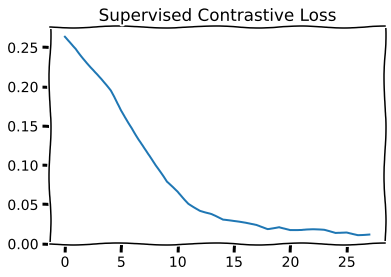

In [16]:
EPOCHS = num_epochs
train_loss_results = []

epoch_time = 0
total_time = 0
for epoch in range(EPOCHS):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()

    for (images, labels) in train_ds:
        loss = train_step(images, labels)
        epoch_loss_avg.update_state(loss) 

    train_loss_results.append(epoch_loss_avg.result())
    
    print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

    end = time.time()
    epoch_time = end - start
    total_time += epoch_time
    
    print(f"Epoch Time: {epoch_time}")
    print(f"Total Time: {total_time}")
    
with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

In [17]:
encoder_r.save('encoder_model.h5')
projector_z.save('projection_model.h5')

In [18]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(2, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model

In [ ]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


checkpoint = ModelCheckpoint('best_model_contrastive.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
#es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
    #restore_best_weights=True, verbose=2)

lr_scheduler = LearningRateScheduler(lr_schedule)
    
supervised_classifier.fit(train_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    callbacks=[checkpoint, lr_scheduler])

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.5001
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.50000, saving model to best_model_contrastive.h5
984/984 [==============================] - 59s 60ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  0.001
Epoch 2/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.4999
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 58s 59ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  0.001
Epoch 3/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.4997
Epoch 00003: val_sparse_categorical_accuracy did not i

Learning rate:  0.0001
Epoch 23/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.4999
Epoch 00023: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 58s 59ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  0.0001
Epoch 24/50
984/984 [==============================] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.5000
Epoch 00024: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 57s 58ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  0.0001
Epoch 25/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.5000
Epoch 00025: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================]

Learning rate:  1e-05
Epoch 45/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.4997
Epoch 00045: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 57s 58ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  1e-05
Epoch 46/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.5000
Epoch 00046: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 58s 59ms/step - loss: nan - sparse_categorical_accuracy: 0.5000 - val_loss: nan - val_sparse_categorical_accuracy: 0.5000
Learning rate:  1e-05
Epoch 47/50
983/984 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.5001
Epoch 00047: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 

In [ ]:
# Testing

import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
testDir  = "/home/trojan/Desktop/dimentia/data_10slices/data_2categ/dataset_augmented/test/CN"
CATEGORIES = ['AD', 'CN']
folders_AD = ['1', '2', '3', '4', '5', '6', '7', '8']
folders_CN = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [ ]:
for folder in folders_CN:
    PATH = os.path.join(testDir, folder)
    for img in os.listdir(PATH):
        img_array = cv2.imread(os.path.join(PATH,img) ,cv2.IMREAD_COLOR)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break 

In [ ]:
def prepare(filepath):
    IMG_SIZE = 256
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    new_array = cv2.normalize(new_array , None, 0, 1, cv2.NORM_MINMAX)
    new_array = new_array.astype('float32')
    #new_array_mean = np.mean(new_array, axis=0)
    #new_array -= new_array_mean
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
patient = 1
AD_patient = 0
CN_patient = 0

for folder in folders_CN:
    PATH = os.path.join(testDir, folder)
    count_AD = 0
    count_CN = 0
    print('Testing for patient {}'.format(patient))
    for img in os.listdir(PATH):
        prediction = supervised_classifier.predict([prepare(os.path.join(PATH,img))])
        #prediction = (supervised_classifier.predict([prepare(os.path.join(PATH,img))])>0.5).astype("int32")
        predicted_class_indice=np.argmax(prediction,axis=-1)
        predicted_class = CATEGORIES[int(predicted_class_indice)]
        #print(predicted_class_indice)
        print(predicted_class_indice)
        print(predicted_class)
        if predicted_class == 'AD':
            count_AD += 1
        else:
            count_CN += 1
    
    print(f"AD votes = {count_AD}")
    print(f"CN votes = {count_CN}")
    
    if count_AD > count_CN:
        print('Patient belongs to AD')
        AD_patient += 1
    else:
        print('Patient belongs to CN')
        CN_patient += 1
    
    patient += 1
    
accuracy = (CN_patient/len(folders_CN))*100
print(f"Accuracy is {accuracy}%")